In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os
pd.set_option('display.float_format', '{:.4f}'.format)

ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

client = oandapyV20.API(access_token=token)

In [2]:
# Loop to create the dataset
Date = pd.Series(datetime.datetime(2010, 1, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 5:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=5)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M5"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    eurusd = eurusd.append(newEurusd)

In [3]:
eurusd.head()

,Time,Open,High,Low,Close
0,2010-01-03 17:50:00,1.43120,1.43120,1.43120,1.43120
1,2010-01-03 17:55:00,1.43172,1.43172,1.43172,1.43172
2,2010-01-03 18:00:00,1.43172,1.43328,1.43172,1.43328
3,2010-01-03 18:05:00,1.43323,1.43425,1.43150,1.43150
4,2010-01-03 18:10:00,1.43105,1.43150,1.43105,1.43110


In [131]:
#eurusd.to_csv(os.getcwd()+'\\eurusd5min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd5min.csv', index_col=0)

In [132]:
# Exponential Moving Averages
eurusd["ema40"] = eurusd["Close"].ewm(span=40, min_periods=40, adjust=False).mean()
deviation = 0.0015
eurusd["UL"] = eurusd["ema40"] + (eurusd["ema40"] * deviation)
eurusd["LL"] = eurusd["ema40"] - (eurusd["ema40"] * deviation)

In [133]:
eurusd = eurusd.iloc[39:]
eurusd.index = range(eurusd.shape[0])

In [134]:
eurusd.head(5)

,Time,Open,High,Low,Close,ema40,UL,LL
0,2010-01-03 21:05:00,1.4308,1.4309,1.4308,1.4308,1.4313,1.4335,1.4292
1,2010-01-03 21:10:00,1.4309,1.4311,1.4309,1.4310,1.4313,1.4334,1.4291
2,2010-01-03 21:15:00,1.4310,1.4311,1.4310,1.4311,1.4313,1.4334,1.4291
3,2010-01-03 21:20:00,1.4311,1.4311,1.4307,1.4308,1.4313,1.4334,1.4291
4,2010-01-03 21:25:00,1.4308,1.4309,1.4308,1.4308,1.4312,1.4334,1.4291


In [135]:
eurusd["buyTrigger"] = 0
eurusd["buyWin"] = 0 
eurusd["sellTrigger"] = 0 
eurusd["sellWin"] = 0 

eurusd["buyTrigger"] = np.where(eurusd["Close"] < eurusd["LL"], 1,0)
eurusd["buyWin"] = np.where(eurusd["Close"] > eurusd["UL"], 1,0)
eurusd["sellTrigger"] = np.where(eurusd["Close"] > eurusd["UL"], 1,0)
eurusd["sellWin"] = np.where(eurusd["Close"] < eurusd["LL"], 1,0)

In [260]:
eurusdBuy = eurusd.drop(["sellTrigger","sellWin"], axis=1)
eurusdSell = eurusd.drop(["buyTrigger","buyWin"], axis=1)

### Long

In [261]:
# To start the dataset with a buyTrigger==1
eurusdBuy = eurusdBuy.iloc[37:]
eurusdBuy.index = range(eurusdBuy.shape[0])

In [262]:
splits = np.append(np.where(np.diff(eurusdBuy["buyWin"]) != 0)[0]+1,len(eurusdBuy["buyWin"]))
prev = 0
price = []
exit = []
totSize = []
tradeCount = []
time = []
totFees = []
z=0 #element just to check that the for loop is running

for split in splits[:-2]:
    
    z=z+1
    indici = []
    indiciWhereBuy = []
    entryList = []
    sizeList = []
    fees = []
    size=2000
    
    indici = np.arange(0,eurusdBuy["buyTrigger"].size,1)[prev:split]
    indiciWhereBuy = np.where(eurusdBuy["buyTrigger"].loc[indici]==1)[0]
    indiciWhereBuy = indiciWhereBuy + prev
    if len(indiciWhereBuy)>0:
        lastEntry = eurusdBuy["Close"].loc[indiciWhereBuy[0]]
        for i in range(len(indiciWhereBuy)-1):
            if eurusdBuy["Close"].loc[indiciWhereBuy[i+1]] < lastEntry - 0.0005:
                lastEntry = eurusdBuy["Close"].loc[indiciWhereBuy[i+1]]
                size=size*1.25
                entryList.append(lastEntry * size)
                sizeList.append(size)
                fees.append(size*0.00008)
        
        price.append(sum(entryList))
        totSize.append(sum(sizeList))
        tradeCount.append(len(entryList))
        exit.append(eurusdBuy["High"][split])
        totFees.append(sum(fees))
        time.append(eurusdBuy["Time"].loc[prev])
    
        prev = split

In [278]:
data = {"Time": time, 'Price':price, 'Exit':exit, 'TradeExecuted':tradeCount, 'Size':totSize, "Fees":totFees}
long = pd.DataFrame(data=data, index=range(len(time)))

In [279]:
long = long[long["TradeExecuted"]!=0]

In [280]:
long["AveragePrice"] = long["Price"]/long["Size"]
long = long[["Time", "AveragePrice", 'Exit', 'TradeExecuted', 'Size', "Fees"]]
long['Pips'] = (long["Exit"] - long["AveragePrice"])*10000
long["P/L"] = long["Size"]*(long["Exit"] - long["AveragePrice"])-long["Fees"]

In [281]:
# Due to my account equity, it's unrealistic that I will be able to average down my entry opening 30 trades
size=2000
sizeList = []
for i in range(30):
    sizeList.append(size)
    size = size*1.25

round(sum(sizeList),1)

6454348.5

In [282]:
postiveAvg = long["P/L"][(long["TradeExecuted"]>10) & (long["P/L"]>0)].mean()
negativeAvg = long["P/L"][(long["TradeExecuted"]>10) & (long["P/L"]<0)].mean()
print("the avg positive P/L when I would avg down my entry with more than 10 trades is " + str(round(postiveAvg)))
print("the avg negative P/L when I would avg down my entry with more than 10 trades is " + str(round(negativeAvg)))

postiveAvg = long["P/L"][(long["TradeExecuted"]<10) & (long["P/L"]>0)].mean()
negativeAvg = long["P/L"][(long["TradeExecuted"]<10) & (long["P/L"]<0)].mean()
print("the avg positive P/L when I would avg down my entry with less than 10 trades is " + str(round(postiveAvg)))
print("the avg negative P/L when I would avg down my entry with less than 10 trades is " + str(round(negativeAvg)))

postiveAvg = long["P/L"][(long["TradeExecuted"]==10) & (long["P/L"]>0)].mean()
negativeAvg = long["P/L"][(long["TradeExecuted"]==10) & (long["P/L"]<0)].mean()
print("the avg positive P/L when I would avg down my entry with 10 trades is " + str(round(postiveAvg)))
print("the avg negative P/L when I would avg down my entry with 10 trades is " + str(round(negativeAvg)))

postiveAvg = long["P/L"][(long["TradeExecuted"]>7) & (long["TradeExecuted"]<12) & (long["P/L"]>0)].mean()
negativeAvg = long["P/L"][(long["TradeExecuted"]>7) & (long["TradeExecuted"]<12) & (long["P/L"]<0)].mean()
print("the avg positive P/L when I would avg down my entry with 8-11 trades is " + str(round(postiveAvg)))
print("the avg negative P/L when I would avg down my entry with 8-11 trades is " + str(round(negativeAvg)))

the avg positive P/L when I would avg down my entry with more than 10 trades is 2555
the avg negative P/L when I would avg down my entry with more than 10 trades is -488
the avg positive P/L when I would avg down my entry with less than 10 trades is 59
the avg negative P/L when I would avg down my entry with less than 10 trades is -36
the avg positive P/L when I would avg down my entry with 10 trades is 245
the avg negative P/L when I would avg down my entry with 10 trades is -281
the avg positive P/L when I would avg down my entry with 8-11 trades is 186
the avg negative P/L when I would avg down my entry with 8-11 trades is -67


In [283]:
# Keep trades with 10 or less entries
long["P/L"].loc[(long["TradeExecuted"]>10) & (long["P/L"]>0)] = 180
long["P/L"].loc[(long["TradeExecuted"]>10) & (long["P/L"]<0)] = -70

long.index = range(long.shape[0])

long.head(5)

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Time,AveragePrice,Exit,TradeExecuted,Size,Fees,Pips,P/L
0,2010-01-04 00:10:00,1.4267,1.4320,3,9531.2500,0.7625,52.7377,49.5031
1,2010-01-04 08:00:00,1.4413,1.4452,1,2500.0000,0.2000,38.8000,9.5000
2,2010-01-05 12:40:00,1.4334,1.4371,7,37683.7158,3.0147,36.9571,136.2534
3,2010-01-06 09:30:00,1.4305,1.4370,11,106415.3218,8.5132,64.8432,180.0000
4,2010-01-13 11:00:00,1.4495,1.4539,4,14414.0625,1.1531,44.7886,63.4055


In [285]:
#long.to_csv(os.getcwd()+'\\eurusd_long.csv')
long = pd.read_csv(os.getcwd()+'\\eurusd_long.csv', index_col=0)

In [284]:
round(long["P/L"].sum())

103478.0

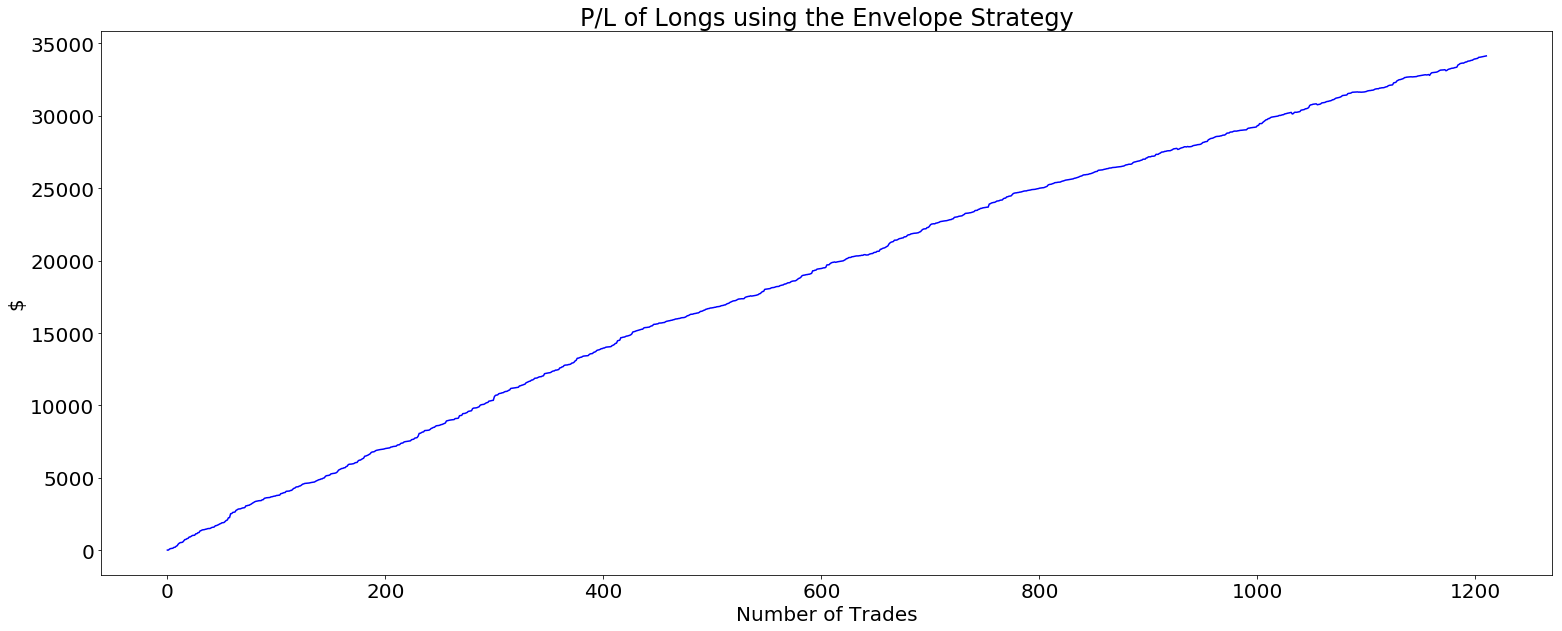

In [286]:
PL = pd.Series(np.cumsum(long["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L of Longs using the Envelope Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

In [287]:
long["P/L"].loc[long["P/L"].idxmax()]

269.5344017028795

In [288]:
long["P/L"].loc[long["P/L"].idxmin()]

-110.30972595214888